Here's my attempt on a python version of plotgrids.ncl: it reads a WPS namelist and shows your domain configuration on a map.

In [124]:
# Import packages
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [125]:
def readnamelistwps(filename):
    ''' Read WPS namelist, convert to float if possible'''

    # Open namelist file and read the lines
    with open(filename,'r') as f:
        lines = [line.strip(',\n') # remove line endings
                     .replace(',',' ') # remove excessive commas
                     .replace("'",' ') # remove excessive string quotes
                     .split() for line in f] # split all elements seperated by blanks into a list of items

    # Create namelist dictionary
    namelist = {}
    for line in lines:
        if len(line)>3: # Lines with namelist variables with at least four elements: name, '=', value1,value2
            try: 
                namelist[line[0]]=[float(x) for x in line[2:]]
            except ValueError:
                namelist[line[0]]=line[2:]

        elif len(line)>2: # Lines with namelist variables have at least three elements: name, '=', value1
            try: 
                namelist[line[0]]=float(line[2])
            except ValueError:
                namelist[line[0]]=line[2]
    
    return namelist

# Preview
namelist = readnamelistwps('namelist.wps.3nest')
namelist

{'dx': [27000.0, 9000.0, 3000.0],
 'dy': [27000.0, 9000.0, 3000.0],
 'e_sn': [91.0, 151.0, 181.0],
 'e_we': [91.0, 151.0, 199.0],
 'end_date': ['2012-05-24_00:00:00',
  '2012-05-24_00:00:00',
  '2012-05-24_00:00:00'],
 'fg_name': ['PRES', 'FILE'],
 'geog_data_path': '/lustre/backup/WUR/ESG/data/MODEL_DATA/WRF/geog_v3.6',
 'geog_data_res': ['10m', '2m', '30s'],
 'i_parent_start': [1.0, 19.0, 49.0],
 'interval_seconds': 21600.0,
 'io_form_geogrid': 2.0,
 'io_form_metgrid': 2.0,
 'j_parent_start': [1.0, 19.0, 34.0],
 'map_proj': 'lambert',
 'max_dom': 3.0,
 'out_format': 'WPS',
 'parent_grid_ratio': [1.0, 3.0, 3.0],
 'parent_id': [1.0, 1.0, 2.0],
 'prefix': 'FILE',
 'ref_lat': 53.86,
 'ref_lon': 3.44,
 'stand_lon': 0.0,
 'start_date': ['2012-05-22_00:00:00',
  '2012-05-22_00:00:00',
  '2012-05-22_00:00:00'],
 'truelat1': 30.0,
 'truelat2': 60.0,
 'wrf_core': 'ARW'}

<IPython.core.display.Javascript object>


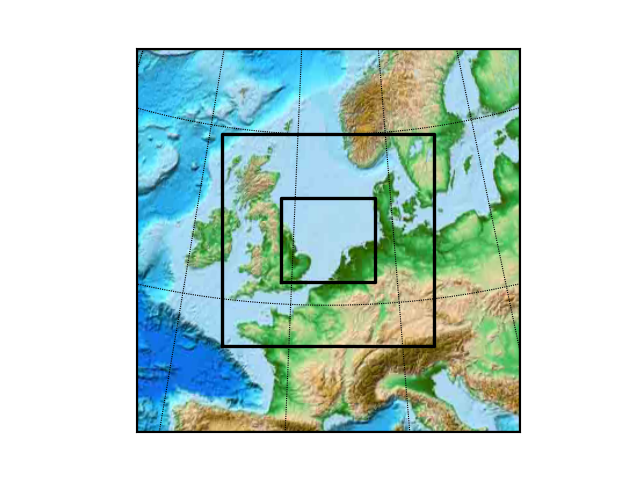

In [126]:
def drawouterdomain(namelist):
    if namelist['max_dom']>1:
        width = namelist['dx'][0]*namelist['e_we'][0]
        height = namelist['dy'][0]*namelist['e_sn'][0]
    else: 
        width = namelist['dx']*namelist['e_we']
        height = namelist['dy']*namelist['e_sn']

    # Create basemap instance using namelist variables
    m = Basemap(width=width,height=height,
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',area_thresh=1000.,projection='lcc',\
                lat_1=float(namelist['truelat1']),lat_2=float(namelist['truelat2']),
                lat_0=float(namelist['ref_lat']),lon_0=float(namelist['ref_lon']))
    
    # Fill background
    #m.fillcontinents(color='coral',lake_color='aqua')
    m.etopo() # requires PIL, not on hpc
    
    # Draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,10.))
    m.drawmeridians(np.arange(-180.,181.,10.))

    return m

m = drawouterdomain(namelist)

In [127]:
def drawdomains(ndom,namelist,m):
    '''Given a namelist and the number of the domain, draw domain boundaries on given basemap instance'''
    
    width = namelist['dx'][ndom]*namelist['e_we'][ndom]
    height = namelist['dy'][ndom]*namelist['e_sn'][ndom]

    # Central point
    lon = namelist['ref_lon']
    lat = namelist['ref_lat']
    x,y = m(lon, lat) # convert to figure coordinates (meters)

    # Define the corners of the rectangle (first and last are the same)
    xs=[x-.5*width,x+.5*width,x+.5*width,x-.5*width,x-.5*width]
    ys=[y-.5*height,y-.5*height,y+.5*height,y+.5*height,y-.5*height]

    # Draw the contours
    m.plot(xs,ys,lw=3,color='k')
    
    return

for x in range(int(namelist['max_dom'])):
    drawdomains(x,namelist,m)